In [30]:
from itertools import chain
from itertools import product
import numpy as np
import anndata as ad
import pandas as pd

import scanpy as sc
import scanpy.external as sce

# import scvelo as scv
# import cellrank as cr
import seaborn as sns
from scipy import io
from scipy import sparse

import gc
gc.enable()

In [31]:
import os
os.chdir('/local/workdir/dwm269/scCardiacOrganoid/')

In [32]:
from scripts.py.scantils import *
# from scripts.py.scanplots import *

In [33]:
# Load metadata
meta = pd.read_csv("resources/metadata.csv")
meta = meta.loc[meta["source"]=="Hoang et al",]
meta = meta.loc[meta["include"],]
meta.index = list(range(0, len(meta)))
meta

sample  include                                           data.dir  \
0       D0_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
1       D1_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
2       D4_200um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
3       D4_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
4      D4_1000um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
5       D6_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
6       D8_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
7      D12_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
8    D21_200um_B     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
9      D21_600um     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   
10  D21_1000um_B     True  /workdir/dwm269/scCardiacOrganoid/data/STARsol...   

   pattern  pattern_int timepoint  time_int       cell_line       source  \
0    600um        600.0        D0         0  GCaMP6f hiPSCs  Hoang et al   
1    600um        600.0        D1         1  GCaMP6f hiPSCs  Hoang et al   
2    200um        200.0        D4         4  GCaMP6f hiPSCs  Hoang et al   
3    600um        600.0        D4         4  GCaMP6f hiPSCs  Hoang et al   
4   1000um       1000.0        D4         4  GCaMP6f hiPSCs  Hoang et al   
5    600um        600.0        D6         6  GCaMP6f hiPSCs  Hoang et al   
6    600um        600.0        D8         8  GCaMP6f hiPSCs  Hoang et al   
7    600um        600.0       D12        12  GCaMP6f hiPSCs  Hoang et al   
8    200um        200.0       D21        21  GCaMP6f hiPSCs  Hoang et al   
9    600um        600.0       D21        21  GCaMP6f hiPSCs  Hoang et al   
10  1000um       1000.0       D21        21  GCaMP6f hiPSCs  Hoang et al   

    soupx  soupx_rho_GeneFull  
0   False                 NaN  
1   False                 NaN  
2    True               0.076  
3    True               0.070  
4    True               0.140  
5    True               0.029  
6    True               0.015  
7    True               0.017  
8    True               0.011  
9    True               0.039  
10   True               0.030

# Load and subset data

In [34]:
adata = sc.read_h5ad(
    # filename="data/pyobjs/scCO_v7-4.h5ad" 
    filename="data/pyobjs/scCO_v1c.h5ad"
)

# adata = adata[adata.obs[]]

# https://github.com/scverse/scanpy/issues/2239
adata.uns['log1p']["base"] = None 

In [35]:
adata.obs["cell_types_level1"]

AAACCCAAGTGCAACG    Pluripotent
AAACCCAAGTTGGAGC    Pluripotent
AAACCCACATACCAGT    Pluripotent
AAACCCACATAGAGGC    Pluripotent
AAACCCAGTGCAACAG    Pluripotent
                       ...     
TTTGGTTTCGGATAAA       Mesoderm
TTTGGTTTCTCATGGA       Mesoderm
TTTGTTGAGTGCTCAT       Mesoderm
TTTGTTGTCATCGCTC       Mesoderm
TTTGTTGTCTATGTGG       Endoderm
Name: cell_types_level1, Length: 96401, dtype: category
Categories (4, object): ['Ectoderm', 'Endoderm', 'Mesoderm', 'Pluripotent']

In [36]:
# tmp_cell_types = ['Definitive_Endoderm', 'Foregut_Epithelium', 'Liver_Progenitors'] 
# adata = adata[adata.obs['cell_types'].isin(tmp_cell_types)]

adata = adata[adata.obs['cell_types_level1'] == "Endoderm"]

/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


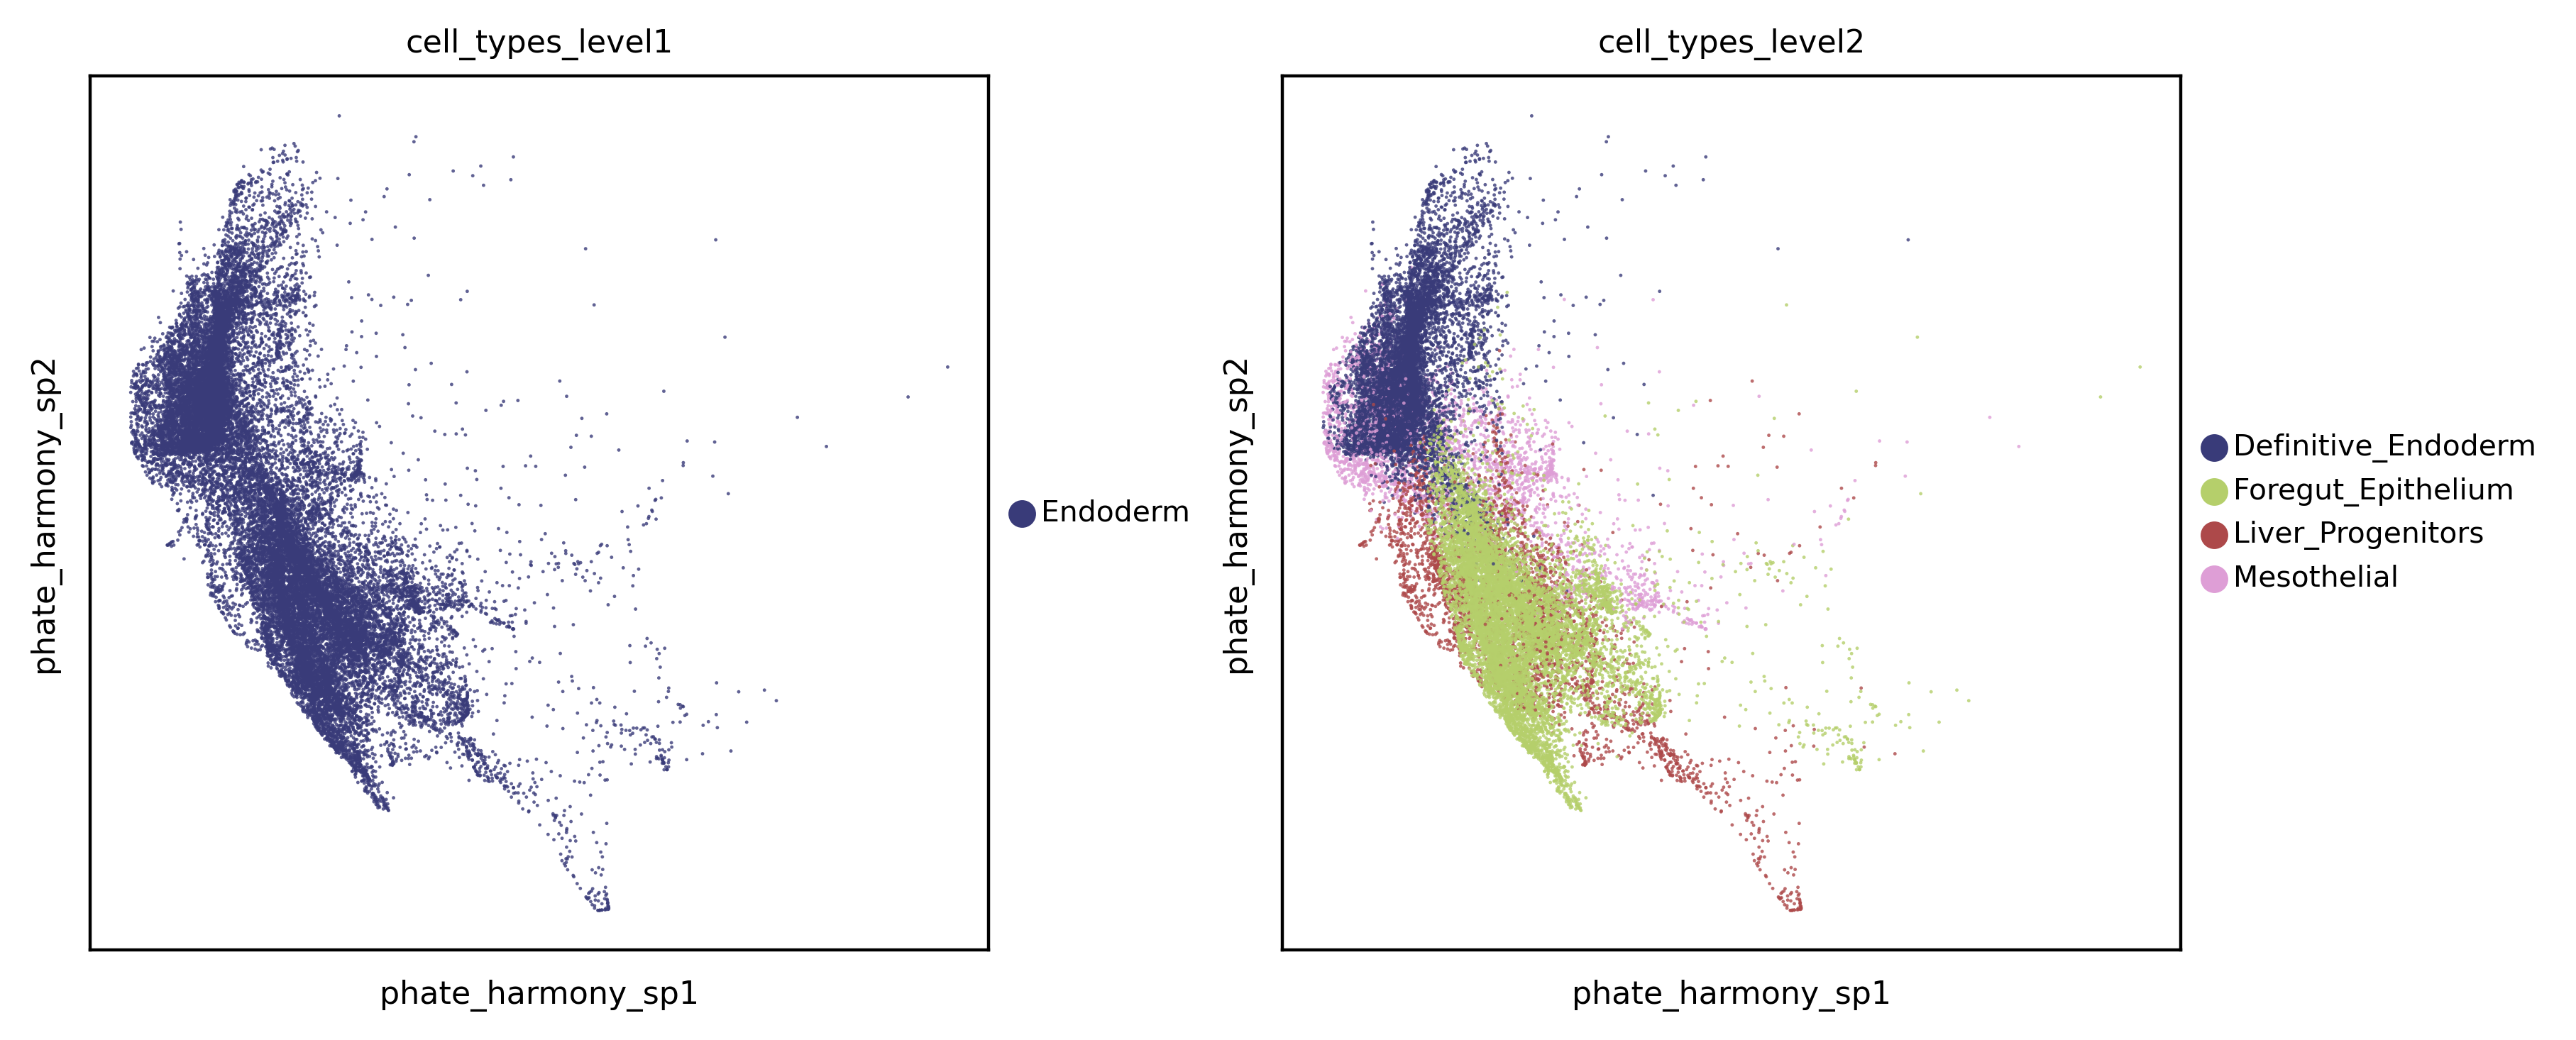

In [37]:
sc.set_figure_params(
    figsize=(4,4),
    fontsize=8,
    transparent=False,
    dpi=200
)
sc.pl.embedding(
    adata,
    basis='phate_harmony_sp',
    color=['cell_types_level1','cell_types_level2'],
    # edges=True, edges_width=0.01, 
    # legend_loc='on data', legend_fontsize=6,legend_fontoutline=1, #labels on plot
    palette='tab20b',
    color_map='cividis',
    size=3, alpha=0.8,
    sort_order=True,
#     return_fig=True,
    ncols=3
)

## Rerun UMAP

In [38]:
sc.pp.neighbors(
    adata,
    n_neighbors=100,
    n_pcs=50,
    use_rep="harmony_sp",
    key_added="harmony_sp_neighbors"
)
gc.collect()

37871

In [39]:
for res in [0.6,0.8, 1.0, 1.2]:
    sc.tl.leiden(
        adata,
        resolution=res, 
        neighbors_key="harmony_sp_neighbors",
        key_added=f"subclusters_{res}"
    )
    gc.collect()

In [40]:
sc.tl.umap(
    adata,
    neighbors_key="harmony_sp_neighbors"
)

/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


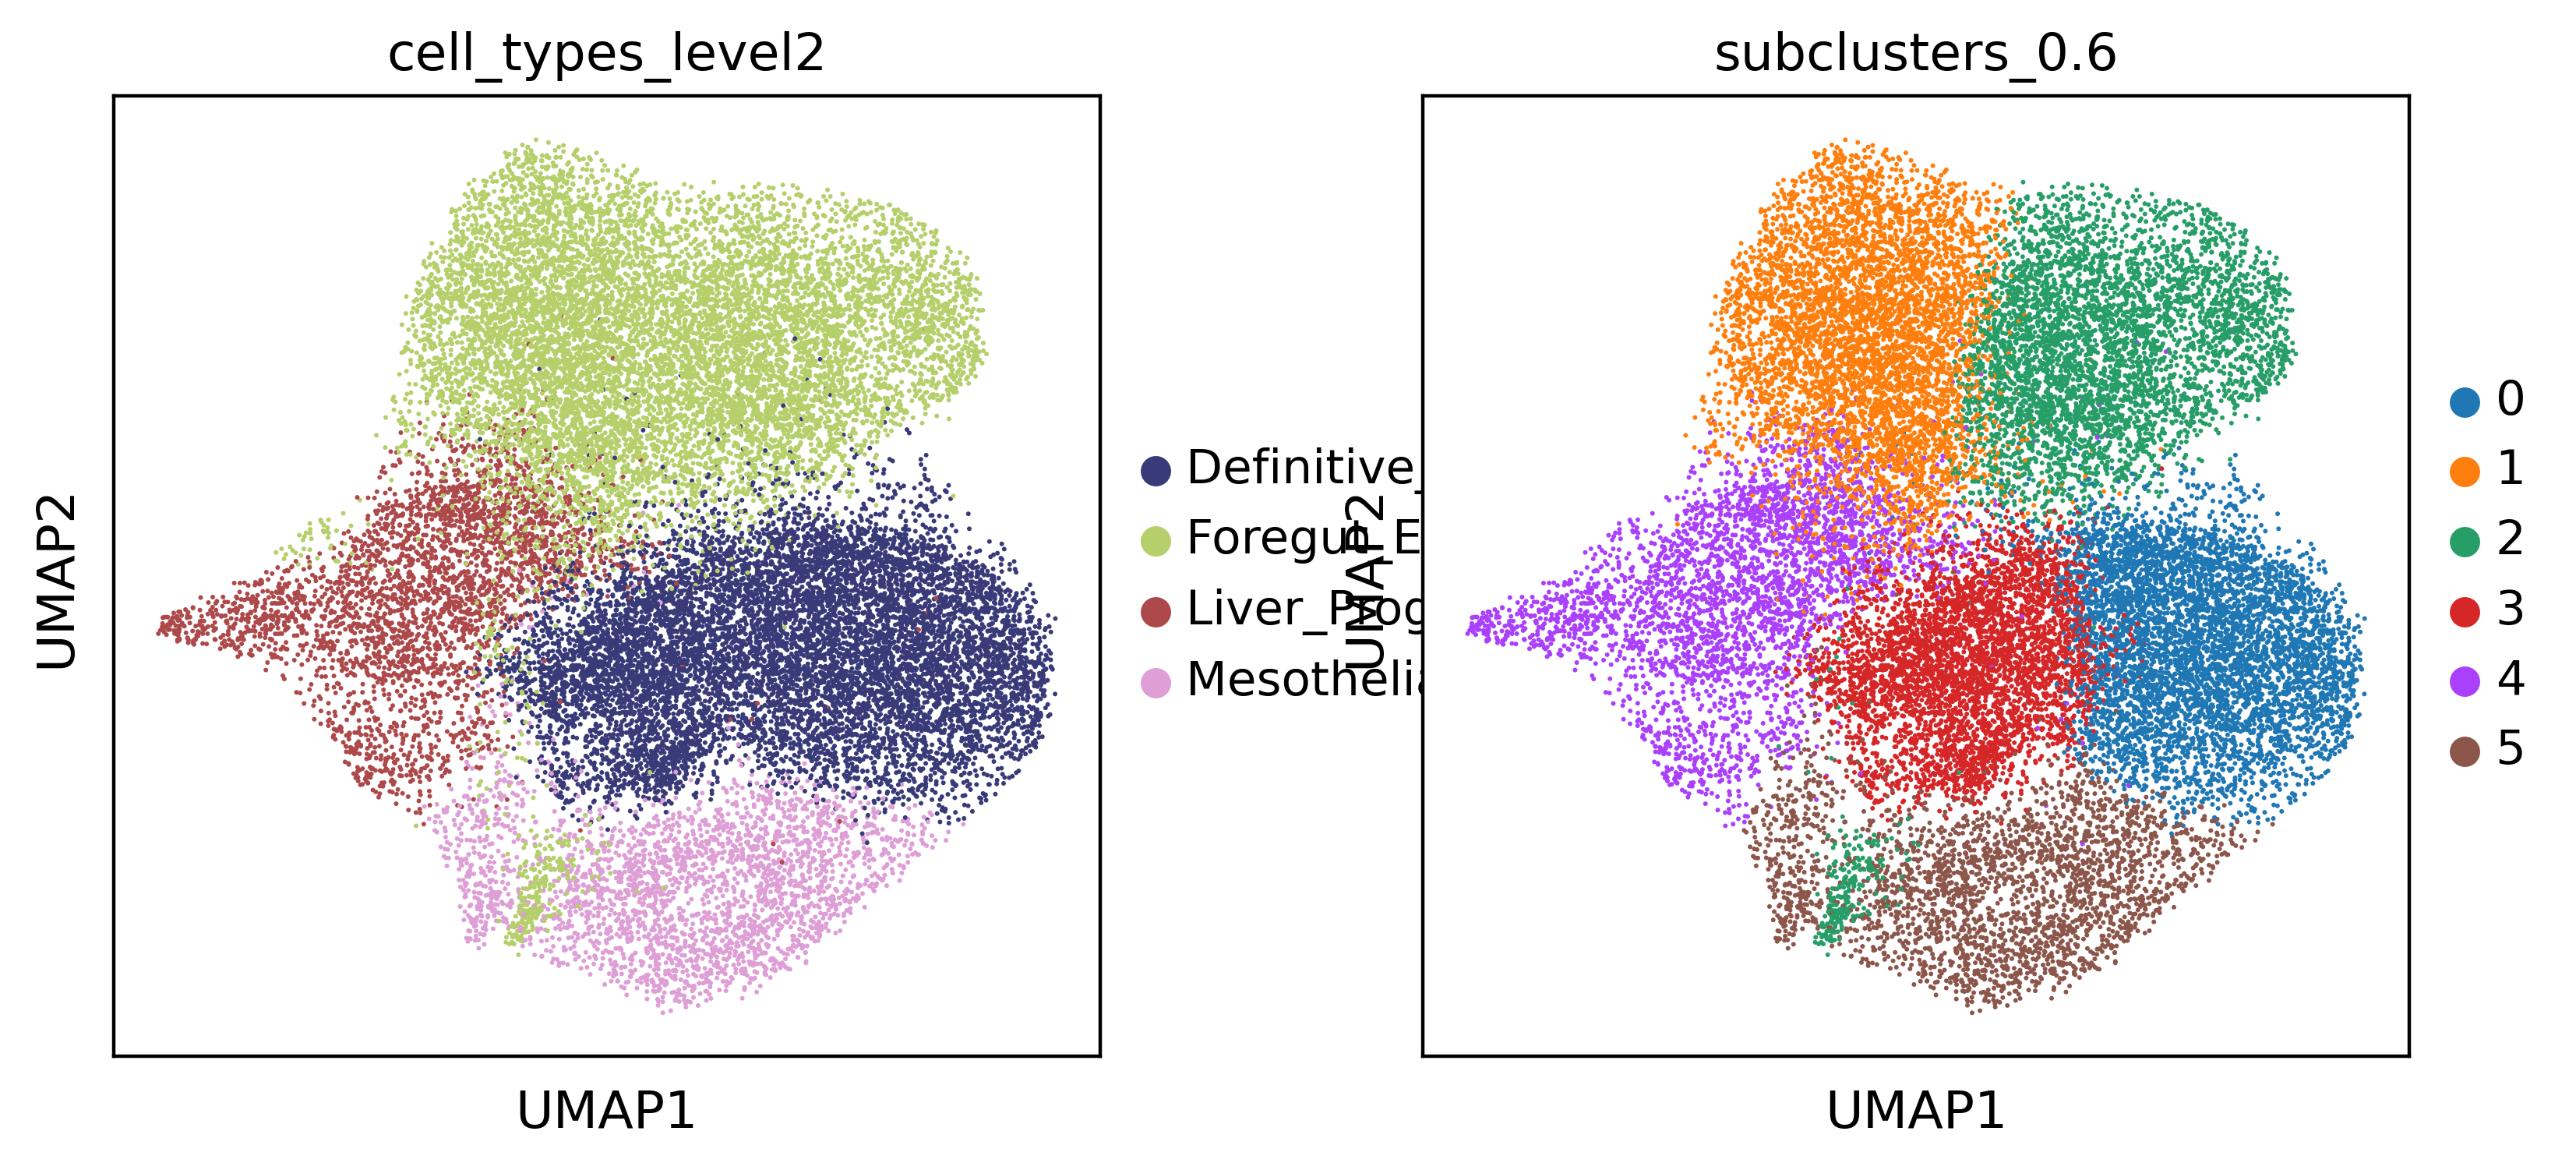

In [49]:
sc.set_figure_params(
    figsize=(4,4),
    fontsize=12,
    transparent=False,
    # dpi_save=400,
    dpi=200
)
sc.pl.umap(
    adata,
    color=[
        "cell_types_level2",
        "subclusters_0.6"
        # "timepoint","pattern"
        ]
)

# DGEA

In [42]:
groupby="cell_types_level2"
sc.tl.rank_genes_groups(
    adata, 
    groupby=groupby, 
    method='wilcoxon',
    layer='data',
    pts=True
)

In [43]:
tmp = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
print(tmp.iloc()[1:20,:])

   Definitive_Endoderm Foregut_Epithelium Liver_Progenitors Mesothelial
1               PTPN13            ONECUT2             APOA1      SLC2A3
2              FAM184A               AMBP              APOB      ANKRD1
3               PCAT14             MALAT1           S100A14      COL4A1
4              COLEC12              ANXA4              RBP4       KRT18
5               MT-CO3             SPINK1             APOC1       RAB17
6        RP11-114G22.1                AFP               GSN     S100A13
7                 CTSV               SOX4              CUBN        FBN2
8                RPS16               SAT1              MTTP       TNNC1
9              MT-RNR1             PARD3B              APOE       PODXL
10           MIR302CHG                VIM             SPARC        KRT8
11              COL4A6              PDE3A             GLUD1       APLP2
12               FGFR1             LYPD6B               FGA       PRAG1
13                 FRY               RBP1               AK4     

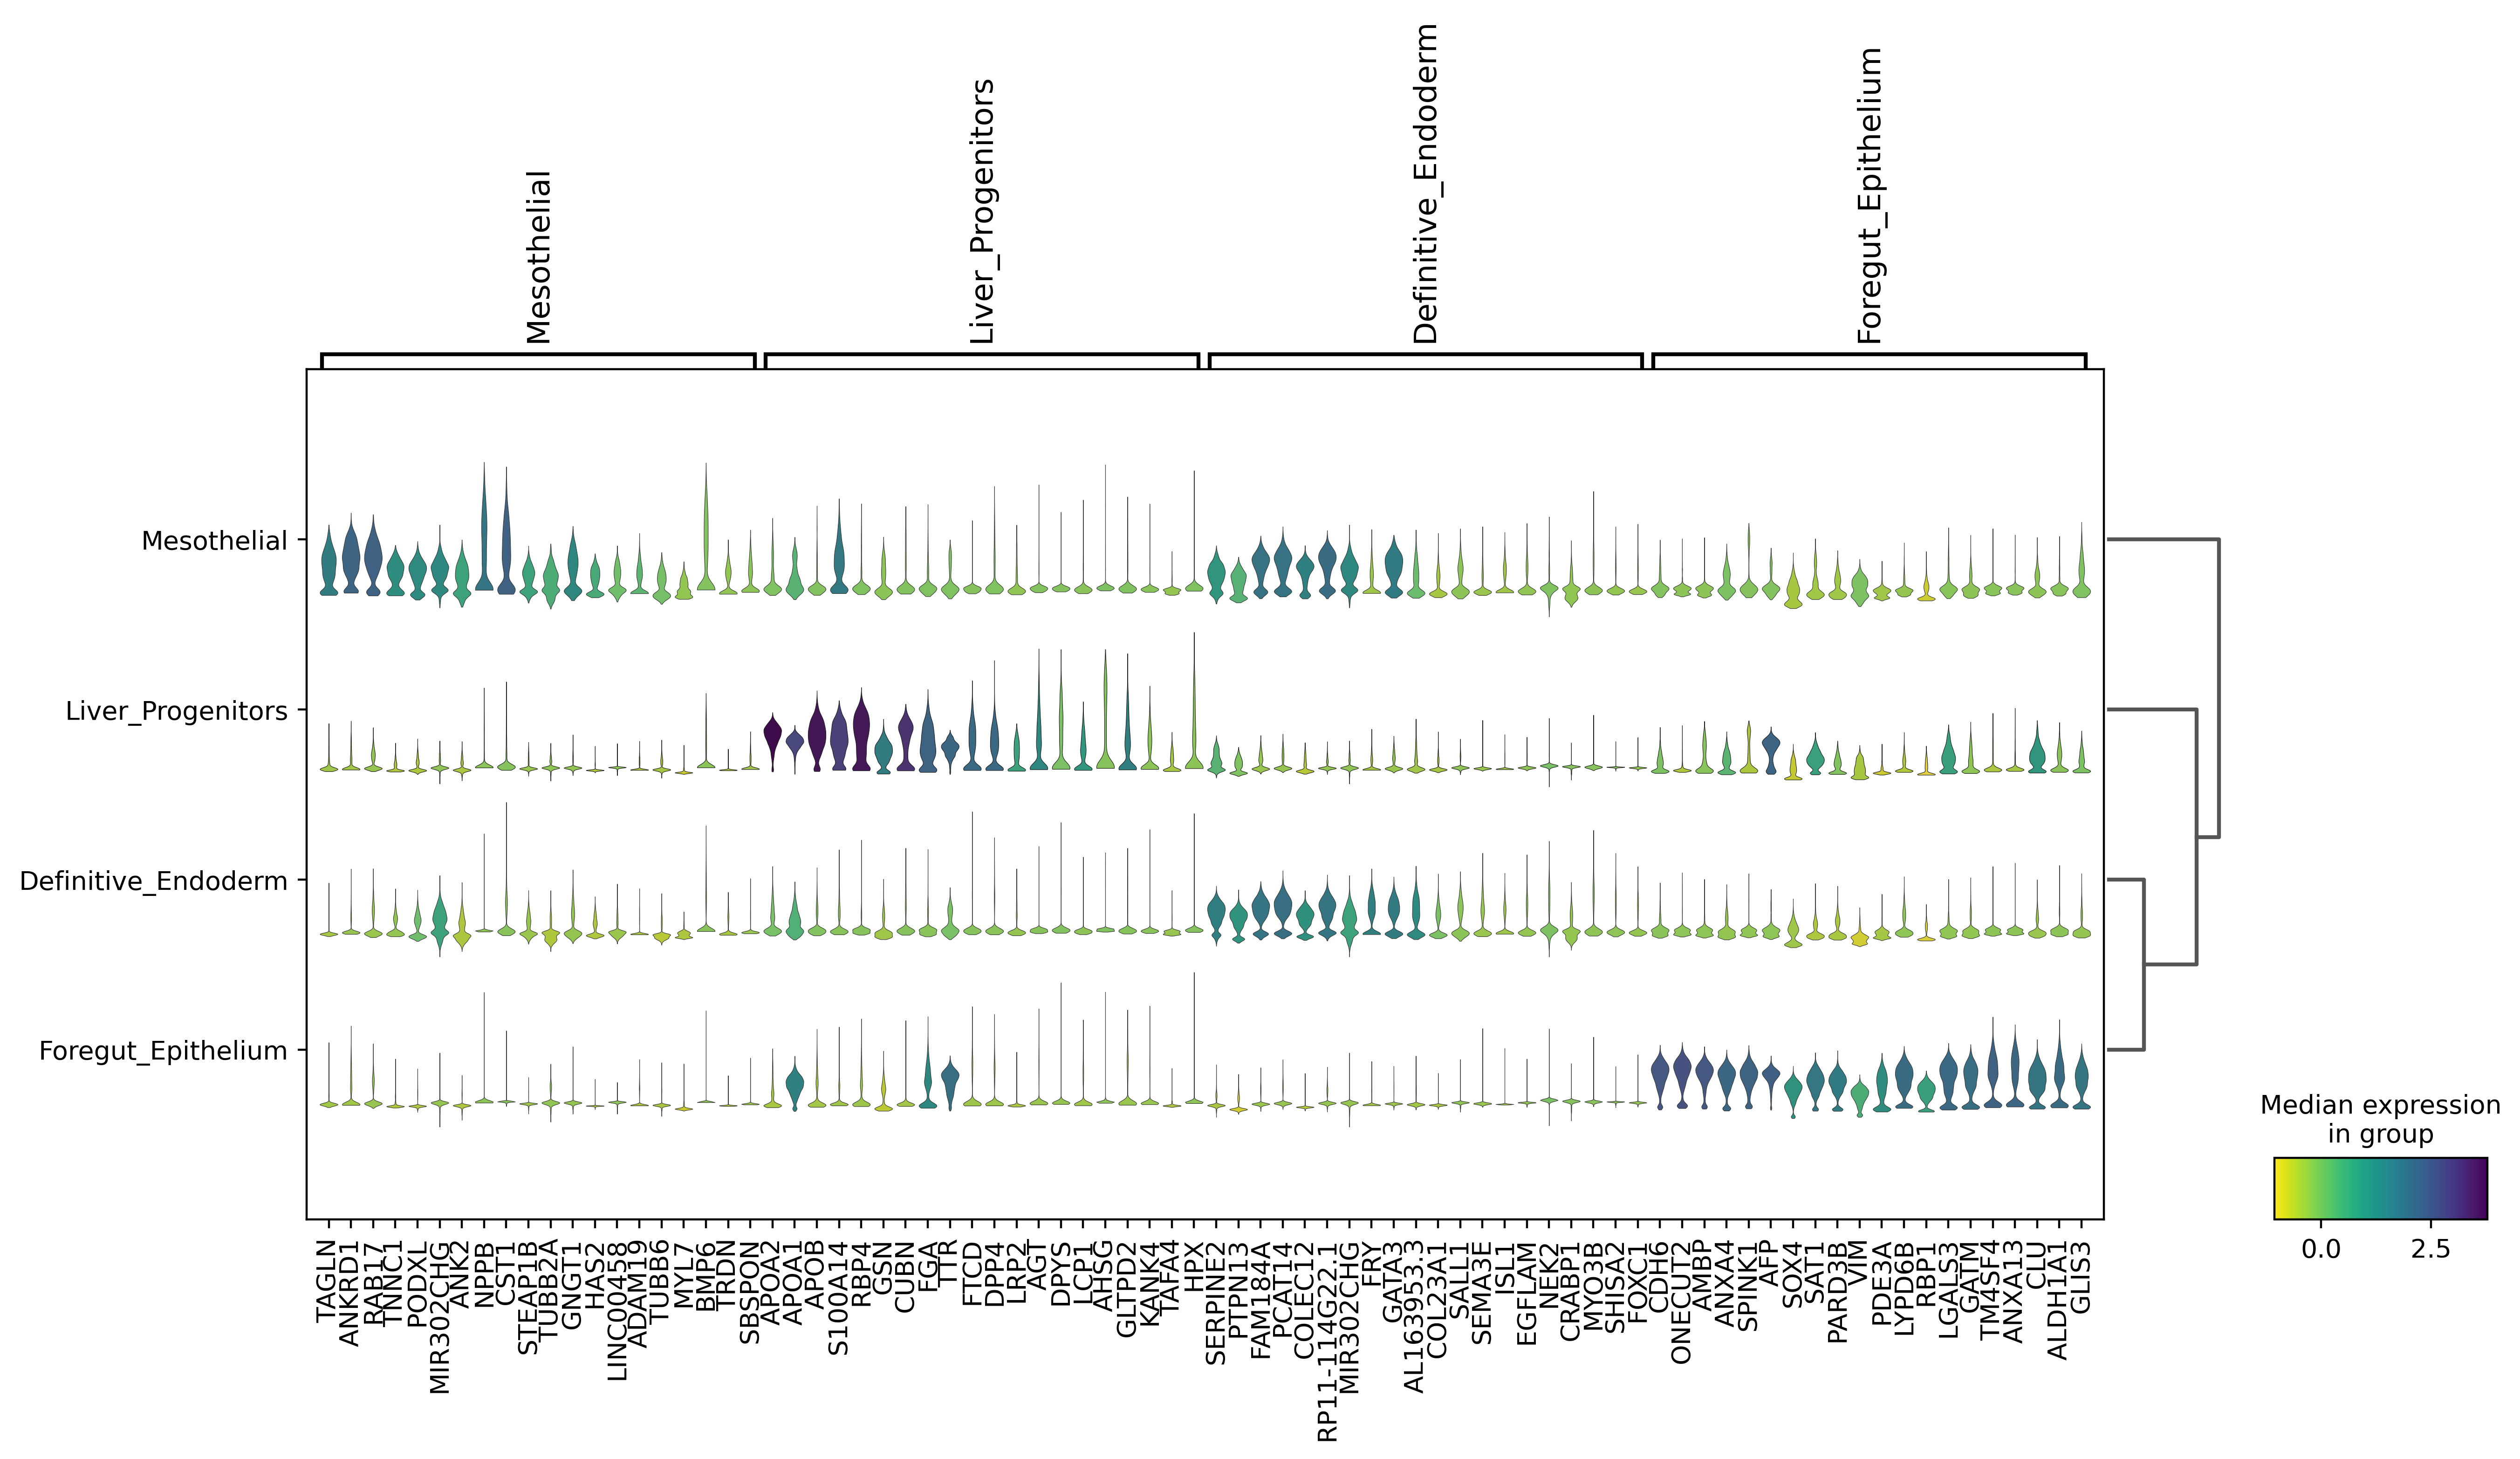

In [44]:
sc.set_figure_params(
    # figsize=(12,16),
    fontsize=12,
    transparent=False,
    # dpi_save=400,
    dpi=200
)

# Rerun dendrogram...
if True:
    sc.tl.dendrogram(
        adata,
        # groupby="leiden_harmony_sp_1.0",
        groupby=groupby,
        n_pcs = npcs(adata,reduction="harmony_sp"),
        use_rep="harmony_sp"
        # var_names=""
    )

sc.pl.rank_genes_groups_stacked_violin(
    adata,
    n_genes=20,
    min_logfoldchange=2.5,
    cmap='viridis_r',
    # return_fig=True,
    figsize=(15,6)
)

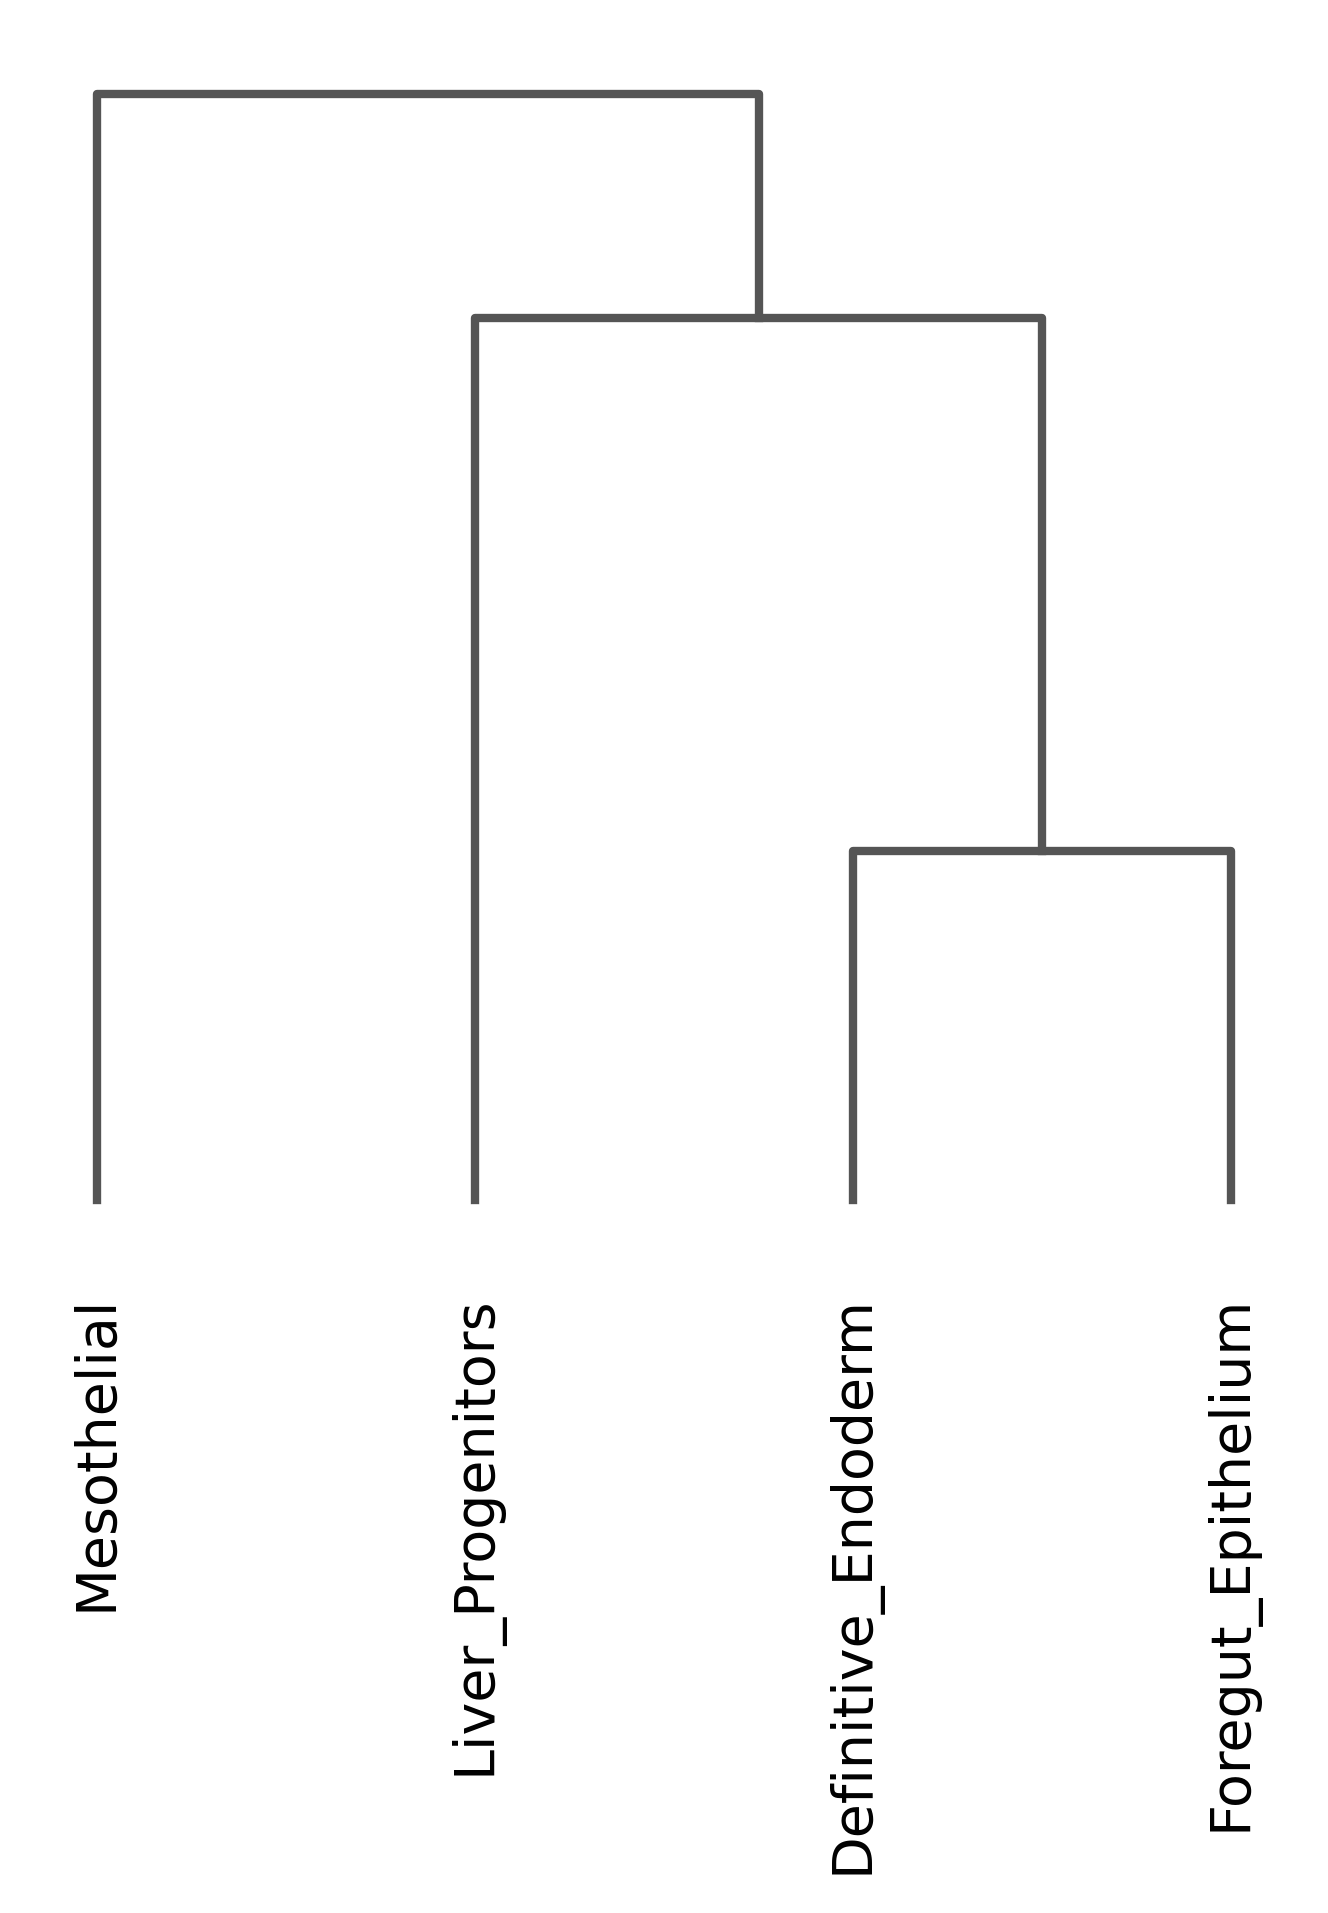

In [45]:
ax = sc.pl.dendrogram(adata, groupby) 

# Re-compute PHATE embedding

In [46]:
import phate

PHATE param combos tried:

```
knn=20,
decay=20,
t='auto'
```

```
knn=50,
decay=20,
t='auto'
```

``` 
knn=20,
decay=100,
t='auto'
```


``` 
knn=20,
decay=40,
t='auto'
```

In [47]:
phate_operator = phate.PHATE(
    knn=20,
    decay=40,
    t='auto',
    mds_solver='smacof',
    n_jobs=32
)

# Use top N harmony dims which account for 95% of variance in harmony embedding
n_dims=npcs(adata,reduction="harmony_sp",var_perc=0.90)
print(f"Using {n_dims} dimensions from `harmony_sp`")

tmp_phate = phate_operator.fit_transform(adata.obsm["harmony_sp"][:,:n_dims]) 
adata.obsm['phate_harmony_sp'] = tmp_phate

Using 40 dimensions from `harmony_sp`
Calculating PHATE...
  Running PHATE on 26053 observations and 40 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 48.36 seconds.
    Calculating affinities...
    Calculated affinities in 0.76 seconds.
  Calculated graph and diffusion operator in 49.47 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.86 seconds.
    Calculating KMeans...
    Calculated KMeans in 22.19 seconds.
  Calculated landmark operator in 29.40 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 4.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 17.25 seconds.
Calculated PHATE in 104.01 seconds.


/home/dwm269/miniconda3/envs/pyRNA6/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


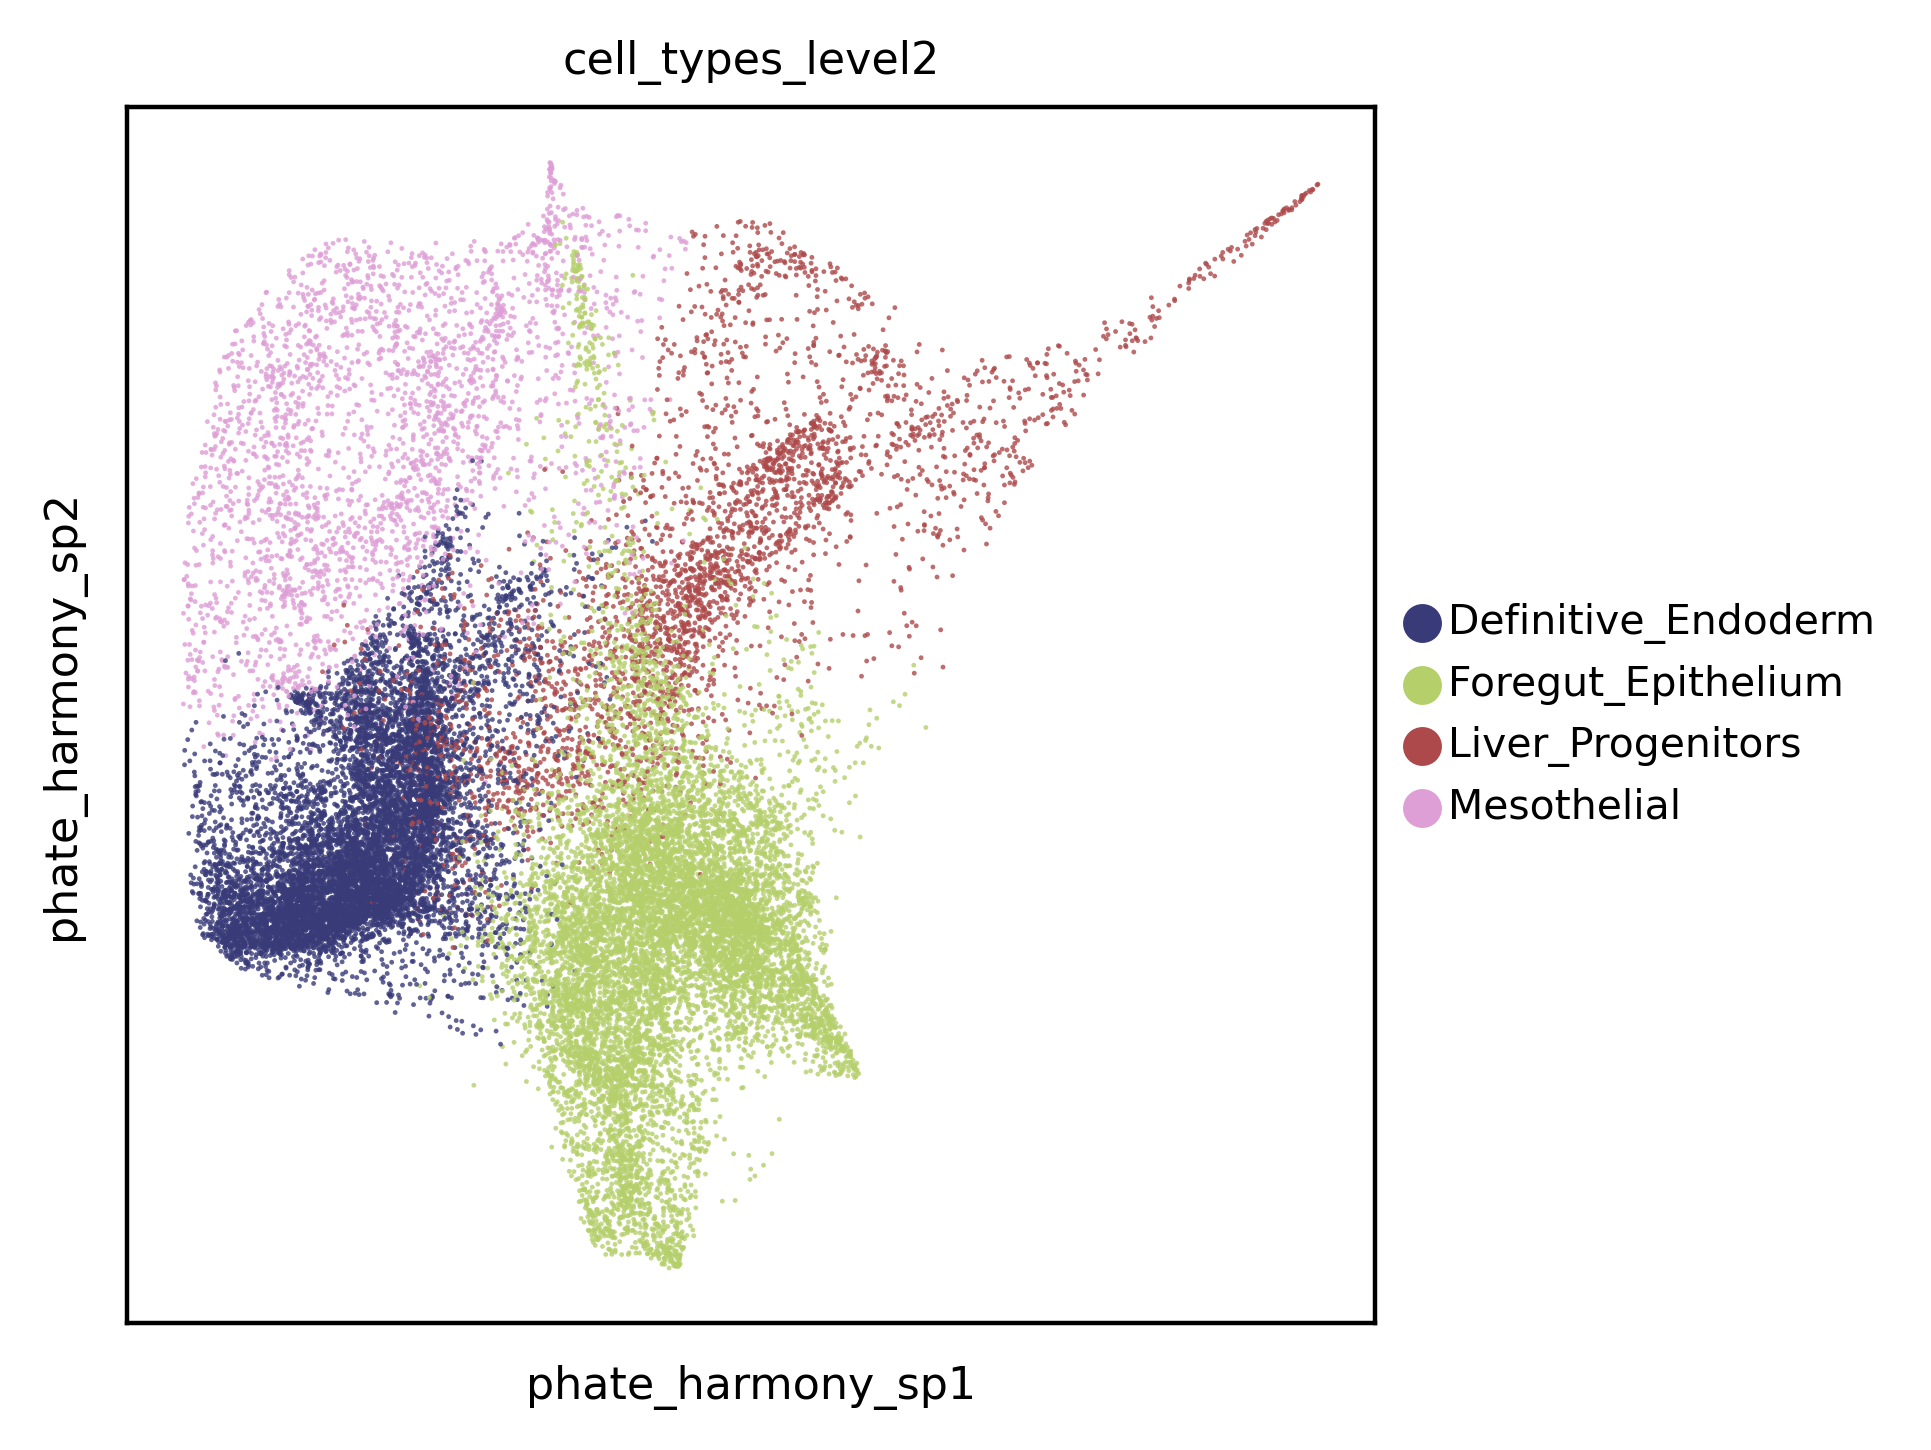

In [48]:
sc.set_figure_params(
    figsize=(4,4),
    fontsize=8,
    transparent=False,
    dpi=200
)
sc.pl.embedding(
    adata,
    basis='phate_harmony_sp',
    # color=['leiden_harmony_sp_10_types','pattern'], 
    color=['cell_types_level2'],
    # edges=True, edges_width=0.01, 
    # legend_loc='on data', legend_fontsize=6,legend_fontoutline=1, #labels on plot
    palette='tab20b',
    # color_map='cividis',
    size=3, alpha=0.8,
    sort_order=True,
#     return_fig=True,
    ncols=3
)